In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [2]:
train=pd.read_csv('train.csv')

# Check for missing value
The data is clean. **No feature contains missing value.**

In [3]:
result=train.isnull().sum()
print('{} features contain missing values.'.format(len(result[result!=0])))

0 features contain missing values.


# Outlier Detection:

In [ ]:
# cols = train.columns
# train[cols[2:12]].boxplot();
# plt.subplots(figsize=(10, 4))
# train[cols[42:52]].boxplot()


With boxplot, we notice that the **features are all rougly bell-shaped and have some obvious outliers**.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

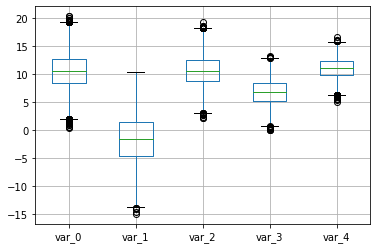

In [4]:
#Apparently there are outliers within the data.
#Besides, the features are all roughly bell-shaped
train[['var_0','var_1','var_2','var_3','var_4']].boxplot()

To double check, I use the Fisher-Pearson coefficint to test the skewness of the variables. Eventually, **all features are roughly bell-shaped**. **All features' skewness coefficients are close to 0**.

In [5]:
#Use Fisher-Pearson coefficient of skewness to address continuous variables' distributions:
# =0 normally distributed
# >0 positively skewed
# <0 negatively skewed
from scipy import stats
numeric_cols=train.columns[2:]
skewness=[]
for i in numeric_cols:
    result=stats.skew(train[i],bias=True)
    skewness.append(result)
skewness_tbl=pd.DataFrame({'numeric columns':numeric_cols,
                           'skewness':skewness})
skewness_tbl.sort_values(by='skewness')

,numeric columns,skewness
44,var_44,-0.340170
93,var_93,-0.238089
81,var_81,-0.232524
80,var_80,-0.220234
86,var_86,-0.216857
...,...,...
163,var_163,0.234778
0,var_0,0.235637
179,var_179,0.242889
2,var_2,0.260312


Given that the features are **roughly normal distributed**, we use **Z-score larger than 3 or smaller than -3 to filter outliers**. Hence, **as long as one feature's value is considered outliers, the entire row is removed.** In the end, **only 5.52%** of data is considered outliers.

In [6]:
#Remove those rows of outliers
train_no_outliers=train[(np.abs(stats.zscore(train.iloc[:,2:]))< 3).all(axis=1)]
print('After excluding the outliers, {}% of data is removed.'.format(round((1-(len(train_no_outliers)/len(train)))*100,2)))

After excluding the outliers, 5.52% of data is removed.


In [7]:
train_no_outliers

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


# Train Validation Split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_no_outliers.iloc[:,2:],train_no_outliers['target'], test_size=0.2, random_state=9)


# Imbalance Data Issue: SMOTE
We notice that the data is extremely imbalanced. Therefore, we will **use both undersampling and oversampling** to fix the issue.

In [9]:
perc=y_train.value_counts()[1]/(y_train.value_counts()[1]+y_train.value_counts()[0])*100
print('The positive cases(Class 1) only take account for {}% of the entire train data.'.format(round(perc,2)))
            

The positive cases(Class 1) only take account for 9.89% of the entire train data.


In [10]:
y_train.value_counts()

0    136218
1     14957
Name: target, dtype: int64

In [11]:
#SMOTE or SMOTEENN on train data
smt=SMOTE()
x_train_smt, y_train_smt = smt.fit_resample(x_train,y_train)

In [12]:
perc=y_train_smt.value_counts()[1]/(y_train_smt.value_counts()[1]+y_train_smt.value_counts()[0])*100
print('After SMOTE, there are totally {} positive cases and {} negative cases.'.format(y_train_smt.value_counts()[1],y_train_smt.value_counts()[0]))
print('The positive cases(Class 1) only take account for {}% of the entire train data.'.format(round(perc,2)))

After SMOTE, there are totally 136218 positive cases and 136218 negative cases.
The positive cases(Class 1) only take account for 50.0% of the entire train data.


In [13]:
x_train_smt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272436 entries, 0 to 272435
Columns: 200 entries, var_0 to var_199
dtypes: float64(200)
memory usage: 415.7 MB


# Logistic Regression with grid-search CV

In [16]:
cv = KFold(n_splits=4, shuffle=True, random_state=42)

In [15]:
from sklearn.linear_model import ElasticNet
# import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

# c = list(range(-5, 10))
# c_values = [10**i for i in c]

# log_grid = {'C': c_values}
# log = LogisticRegression(random_state = 42)
# clf = GridSearchCV(log, log_grid, cv = cv, scoring='f1_micro')
# clf.fit(x_train_smt, y_train_smt)

# #Accuracy of model
# lr_score=clf.score(x_train_smt,y_train_smt)
# print('Accuracy of lr_model :',lr_score)

# # Nested CV with parameter optimization
# nested_score = cross_val_score(clf, X=x_train_smt, y=y_train_smt, cv=cv)
# print(nested_score.mean())
# print("tuned hpyerparameters :(best parameters) ",clf.best_params_)

# XGBoost with grid-search CV



In [ ]:
from xgboost import XGBClassifier


# Define cross-validation set
# inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# XGB hyperparameter
xgb_paramGrid = {'estimator__objective':['binary:logistic'], 'estimator__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
                  'estimator__max_depth': [3,5,7,9,11], 'estimator__gamma':[0.01, 0.1],
                  'estimator__n_estimators':[200, 300, 400, 500], 'estimator__colsample_bytree':[0.3, 0.7]}

# Find the best parameter 
xgb = XGBClassifier(verbosity = 0, class_weight=None)
clf = GridSearchCV(estimator=xgb, param_grid=xgb_paramGrid, n_jobs=-1, cv=cv, scoring='f1_micro', error_score = 'raise')
grid_result = clf.fit(x_train, y_train)

print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of XGBoost is  {grid_result.best_params_}\n")


"""
Best score of gridsearch is 0.8980992323615664
The best hyperparameter of XGBoost is  {'estimator__colsample_bytree': 0.3, 'estimator__gamma': 0.01, 
                                        'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 
                                        'estimator__n_estimators': 200, 'estimator__objective': 'binary:logistic'}
"""


Best score of gridsearch is 0.8980992323615664

The best hyperparameter of XGBoost is  {'estimator__colsample_bytree': 0.3, 'estimator__gamma': 0.01, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__objective': 'binary:logistic'}



# LightGBM with grid-search CV


In [ ]:
from lightgbm import LGBMClassifier

# LGBM hyperparameter
lgbm_paramGrid = {'estimator__objective':['binary'], 'estimator__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
                   'estimator__max_depth': [3,5,7,9,11], 'estimator__n_estimators':[200, 300, 400, 500],
                   'estimator__colsample_bytree':[0.3,0.5, 0.7]}

# Find the best parameter of 
lgbm = LGBMClassifier(verbosity = 0, class_weight=None)
clf = GridSearchCV(estimator=lgbm, param_grid=lgbm_paramGrid, n_jobs=-1, cv=cv, scoring='f1_micro', error_score = 'raise')
grid_result = clf.fit(x_train, y_train)


print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of LightGBM is  {grid_result.best_params_}\n")

"""
Best score of gridsearch is 0.9091913459109097

The best hyperparameter of LightGBM is  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.1, \
'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__objective': 'binary'}
"""


Best score of gridsearch is 0.9091913459109097

The best hyperparameter of LightGBM is  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__objective': 'binary'}

